importing all necessary libraries for ARIMA modelling

In [415]:
#pip install pandas matplotlib seaborn statsmodels pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [180]:
df = pd.read_csv('dfmonthly_modelling.csv', parse_dates=True, index_col='Date')

In [181]:
df = df[['exchange_rate']]

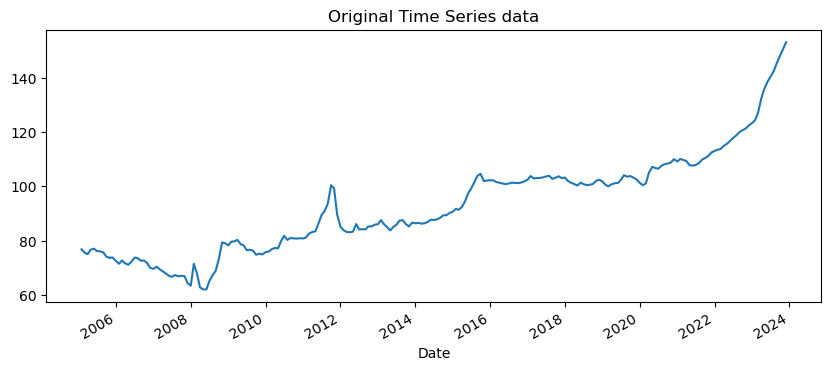

In [182]:
# ploting the data
df['exchange_rate'].plot(title='Original Time Series data', figsize=(10, 4))
plt.show()

Text(0.5, 1.0, 'Log-Transformed Series')

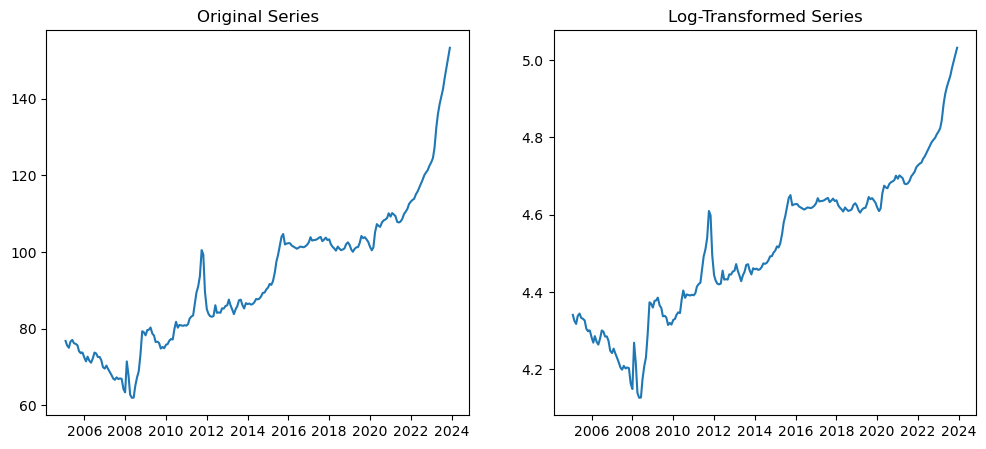

In [183]:
df['log_transformed'] = np.log(df['exchange_rate'])

# Ploting original and log-transformed series
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df['exchange_rate'])
plt.title('Original Series')

plt.subplot(1, 2, 2)
plt.plot(df['log_transformed'])
plt.title('Log-Transformed Series')

the original data and the log trasformed data is plotted to see if with the log the time series can become more stationary. from the plot it can be seen that there is not much difference between the two, for that reason the original timeseries data is considered.

In [184]:
#Spliting the data in test and train, the last 20% are considered as test data 
test_size = int(len(df) * 0.2)
train = df['exchange_rate'][:-test_size]
test = df['exchange_rate'][-test_size:]

# 1. checking for stationarity of time series

## Method 1 ACF and PACF plots to check stationarity

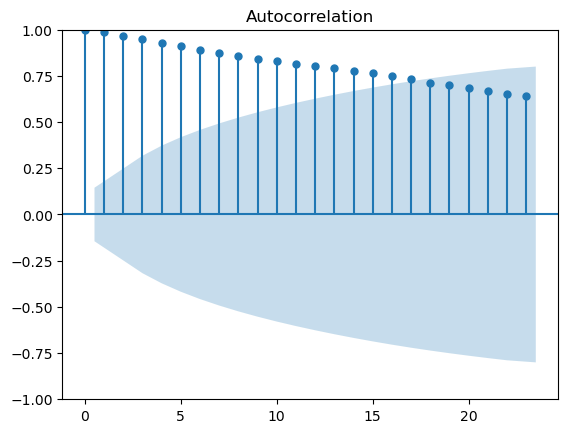

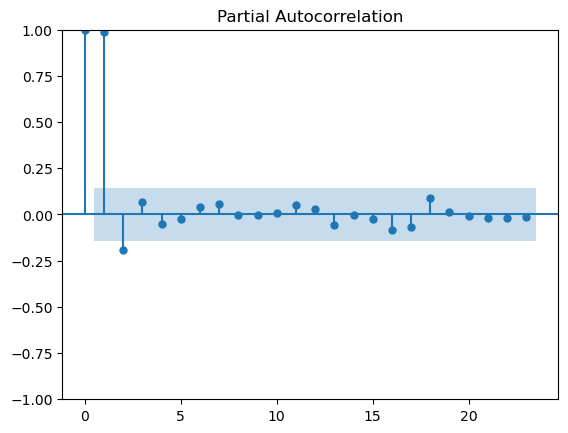

In [185]:
acf_original=plot_acf(train)
pacf_original=plot_pacf(train)

The correlation for lag shows a high positive value with a gradual decay, while the partial autocorrection shows a single high spike at lag 1. This is called random walk and it is a sign that the time series is not stationary.

## method 2 ADF test 

In [186]:
adf_test= adfuller(train)
print(f'p-value:{adf_test[1]}')

p-value:0.7737593612981813


This result shows that the p value is high, meaning it is rejecting the null hypotesis. So the ADF test shows that the time series is not stationary.

# 2. Trasforming the time series to stationary by differencing

<Axes: xlabel='Date'>

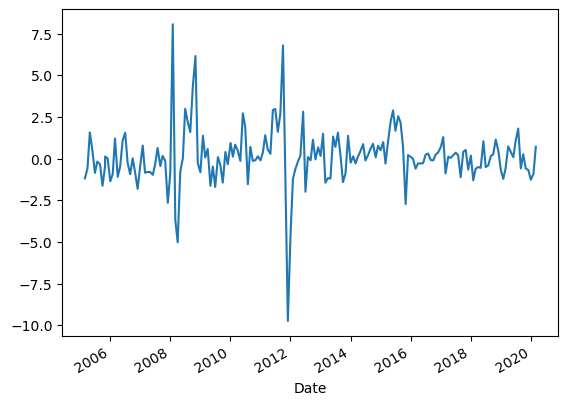

In [187]:
train_diff= train.diff().dropna()
train_diff.plot()

From the plot is looks much stationary in comparison to the original time series. But to be more sure the ACF,PACF and the ADF needs to be plotted.

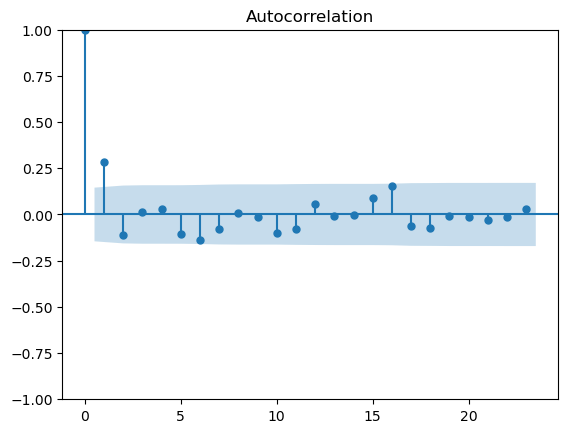

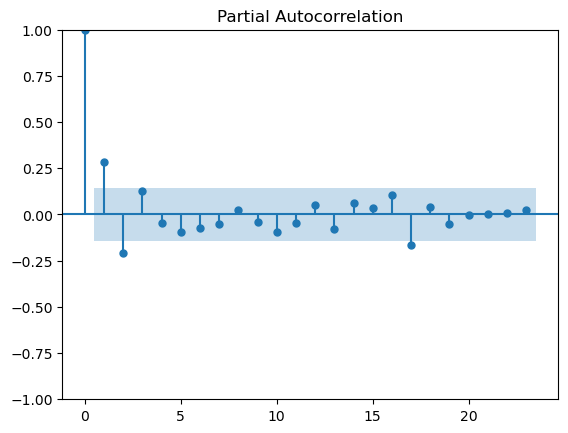

In [188]:
acf_original=plot_acf(train_diff)
pacf_original=plot_pacf(train_diff)

Comapred to the original timeseries the ACF shows less correlation with the lag as we have a very fast decay in lag , while for the PACF the spike at lag 1 has reduced considerably. This are signs that the timeseries is more stationary now in comparison to the original one.

In [189]:
adf_train_diff= adfuller(train_diff)
print(f'p-value:{adf_train_diff[1]}')

p-value:1.1855953215520265e-09


The p-value as well has reduced, and it is smaller that 5%, indicating that the time series is stationary.

## 3. Determining the ARIMA parameters p and q,( ARIMA (p,d,q))

Acording to thumb rule if the PACF plot has a spike at a lag q, but not beyond it. And the ACF plot shows a gradual decay this can suggest that the ARIMA is (0,d,q). so since in our case the modified plot shows a trend described by the thumb rule, the q value from the PACF is equal to 1, where there is a high spike.

## 4. Fit the ARIMA model

In [190]:
model=ARIMA(train,order=(0,1,1))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          exchange_rate   No. Observations:                  183
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -343.219
Date:                Thu, 29 May 2025   AIC                            690.439
Time:                        16:25:55   BIC                            696.847
Sample:                             0   HQIC                           693.036
                                - 183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4187      0.032     13.148      0.000       0.356       0.481
sigma2         2.5414      0.117     21.783      0.000       2.313       2.770
Ljung-Box (L1) (Q):                   0.36   Jarque-

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 5. Time serie prediction

## Plot of Residuals and the Density

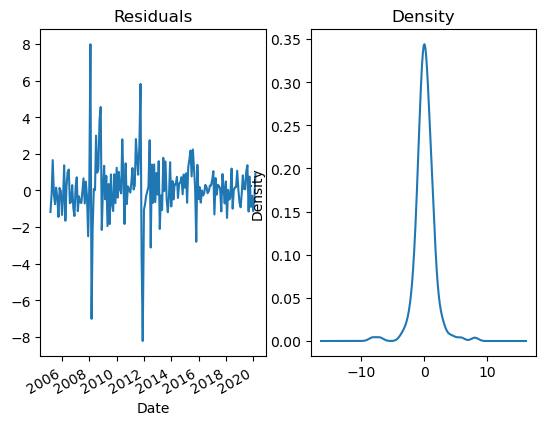

In [191]:
residuals= model_fit.resid[1:]
fig,ax=plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

The density looks normally distributed with mean around 0, while the residuals look random and normal.

## acf and pacf plots of the model residuals

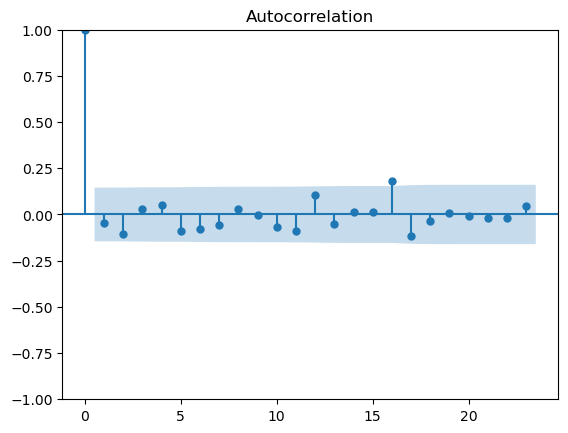

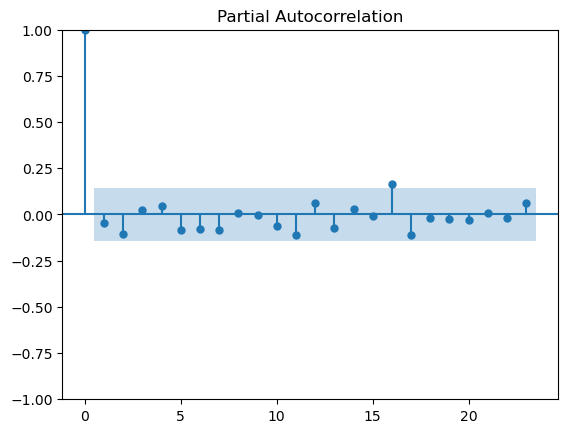

In [192]:
acf_res=plot_acf(residuals)
pacf_res=plot_pacf(residuals)

the spikes at the lower levels have disappeared, showing that the spikes are small closer to white noise. so this is a good result.

## making prediction and plotting them with the original timeseries , to make comparison.

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


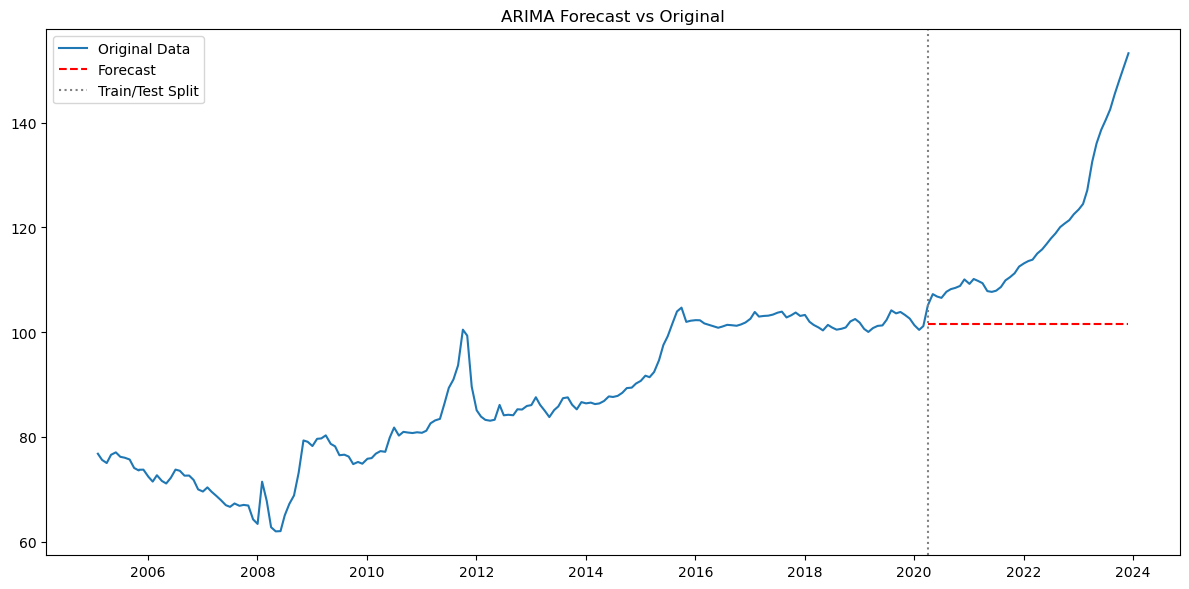

In [193]:
forecast_test=model_fit.forecast(len(test))
df['forecast']=[None]*len(train)+list(forecast_test)
plt.figure(figsize=(12,6))
plt.plot(df['exchange_rate'], label='Original Data')
plt.plot(df['forecast'], label='Forecast', color='red', linestyle='--')
plt.axvline(x=test.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMA Forecast vs Original')
plt.legend()
plt.tight_layout()
plt.show()

It can be seen that the forcast time series shows an orizontal trend while the original one takes an increasing trend.

In [194]:
#forecasting for the next 12 months
future_diff_forecast = model_fit.get_forecast(steps=12).predicted_mean

# Reconstructing original forecasted values
last_actual_value = df.iloc[-1]
future_forecast_values = [last_actual_value + future_diff_forecast.iloc[0]]
for i in range(1, len(future_diff_forecast)):
    future_forecast_values.append(future_forecast_values[i - 1] + future_diff_forecast.iloc[i])

#  Assigning dates to the forecast
future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
future_forecast_series = pd.Series(future_forecast_values, index=future_index)
print(future_forecast_series)

2023-12-31    exchange_rate      254.775907
log_transformed ...
2024-01-31    exchange_rate      356.311814
log_transformed ...
2024-02-29    exchange_rate      457.847721
log_transformed ...
2024-03-31    exchange_rate      559.383628
log_transformed ...
2024-04-30    exchange_rate      660.919535
log_transformed ...
2024-05-31    exchange_rate      762.455442
log_transformed ...
2024-06-30    exchange_rate      863.991349
log_transformed ...
2024-07-31    exchange_rate      965.527256
log_transformed ...
2024-08-31    exchange_rate      1067.063163
log_transformed...
2024-09-30    exchange_rate      1168.599070
log_transformed...
2024-10-31    exchange_rate      1270.134977
log_transformed...
2024-11-30    exchange_rate      1371.670884
log_transformed...
Freq: ME, dtype: object


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\2018786335.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')


# 6. auto-fit the ARIMA model

In [195]:
auto_arima = pm.auto_arima(train, seasonal=False, stepwise=False, trace=True)
print(auto_arima.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=713.268, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=691.797, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=691.969, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=693.543, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=694.892, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=696.358, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=700.034, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=692.387, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=696.749, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=693.858, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=693.367, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC

In [196]:
auto_arima

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

For the auto fit ARIMA the seasonality is 0, and the ARIMA model is (0,1,1), which is the same with the manual one.

# 7. Evaluating the auto ARIMA predictions

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


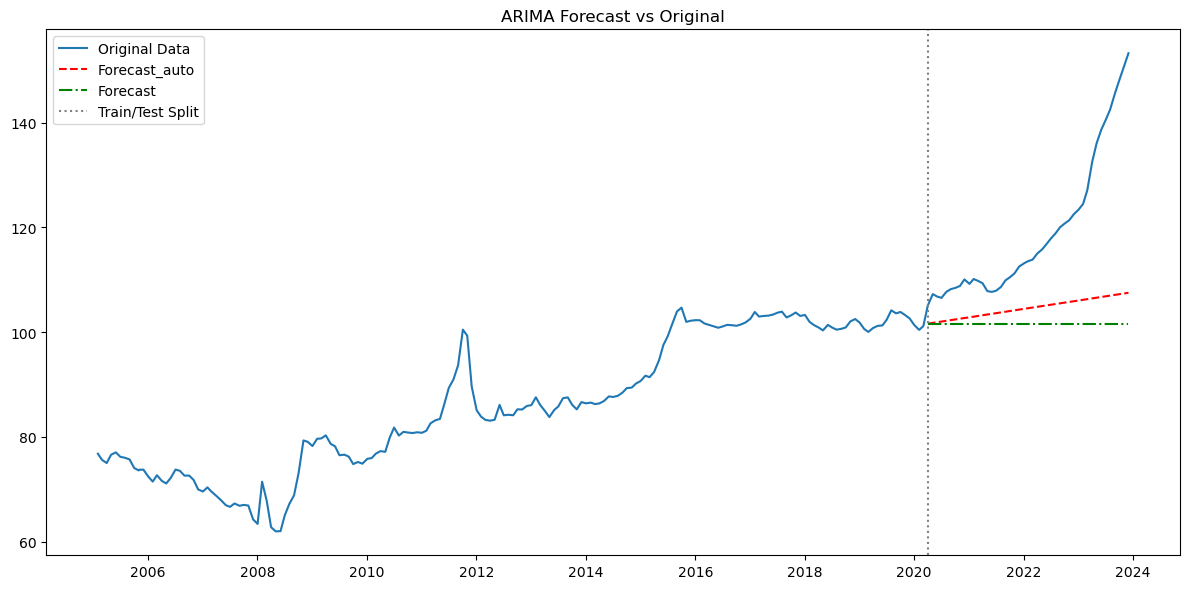

In [197]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df['forecast_auto']=[None]*len(train)+list(forecast_test_auto)
plt.figure(figsize=(12,6))
plt.plot(df['exchange_rate'], label='Original Data')
plt.plot(df['forecast_auto'], label='Forecast_auto', color='red', linestyle='--')
plt.plot(df['forecast'], label='Forecast', color='green', linestyle='-.')
plt.axvline(x=test.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMA Forecast vs Original')
plt.legend()
plt.tight_layout()
plt.show()

In [198]:
# Forecast 
forecast_diff = model_auto.predict(n_periods=12)

last_actual = test.iloc[-1]

forecasted_original = [last_actual + forecast_diff.iloc[0]]   

for i in range(1, len(forecast_diff)):
    forecasted_original.append(forecasted_original[i - 1] + forecast_diff.iloc[i])

last_date = test.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

forecasted_original_series = pd.Series(forecasted_original, index=forecast_index, name='Manual Auto ARIMA Forecast')

print(forecasted_original_series)

2024-01-01     254.775907
2024-02-01     356.311814
2024-03-01     457.847721
2024-04-01     559.383628
2024-05-01     660.919535
2024-06-01     762.455442
2024-07-01     863.991349
2024-08-01     965.527256
2024-09-01    1067.063163
2024-10-01    1168.599070
2024-11-01    1270.134977
2024-12-01    1371.670884
Freq: MS, Name: Manual Auto ARIMA Forecast, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


From the graph , it can be seen that the auto fit ARIMA is doing slightly better than the manual ARIMA as the slope of the trend it much closer to the original time series. Even if the ARIMA value for both is the same they show slight different outcomes, and this is due to intercept handling, internal solver differences and model implementation like the difference between statsmodels and pmdarima models.

## Computing the mean square error and the mean absolute error for the auto fitted ARIMA , manual ARIMA 

In [199]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test

y_pred_manual = df['forecast'].iloc[-len(test):]
mse_manual = mean_squared_error(y_true, y_pred_manual)
mae_manual = mean_absolute_error(y_true, y_pred_manual)

y_pred_auto = df['forecast_auto'].iloc[-len(test):]
mse_auto = mean_squared_error(y_true, y_pred_auto)
mae_auto = mean_absolute_error(y_true, y_pred_auto)

y_pred_naive = [train.iloc[-1]] * len(test)
mse_naive = mean_squared_error(y_true, y_pred_naive)
mae_naive = mean_absolute_error(y_true, y_pred_naive)

print("📊 Forecast Accuracy Metrics:")
print(f"Manual ARIMA    - MSE: {mse_manual:.4f}, MAE: {mae_manual:.4f}")
print(f"Auto ARIMA      - MSE: {mse_auto:.4f}, MAE: {mae_auto:.4f}")
print(f"Naive Forecast  - MSE: {mse_naive:.4f}, MAE: {mae_naive:.4f}")

📊 Forecast Accuracy Metrics:
Manual ARIMA    - MSE: 486.6844, MAE: 17.4913
Auto ARIMA      - MSE: 350.6729, MAE: 14.4544
Naive Forecast  - MSE: 499.9759, MAE: 17.8672


From the MSE and MAE it can be concluded that the auto arima has better results with ARIMA value of (0,1,1)

## Plots of the test data for the 2 models, the auto fitted ARIMA and the manual ARIMA.

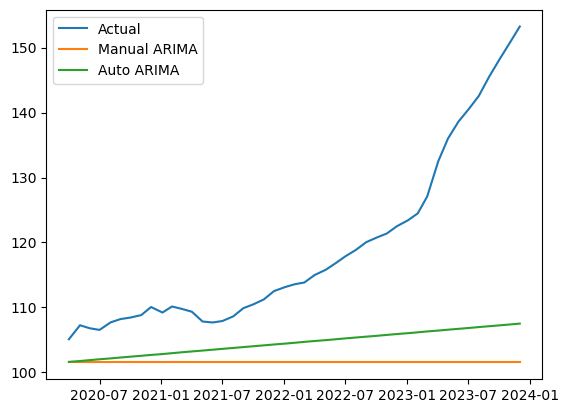

In [200]:
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_test, label='Manual ARIMA')
plt.plot(test.index, forecast_test_auto, label='Auto ARIMA')
plt.legend()

# ARIMAX considering all the features in the forecast

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-pac

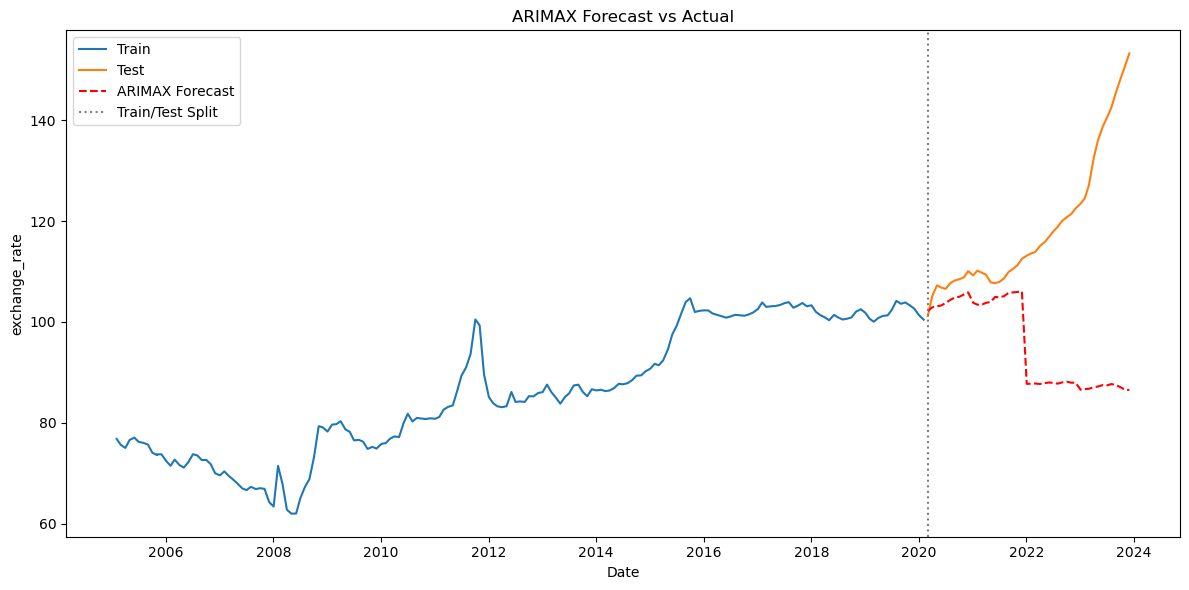

Mean Squared Error (MSE): 956.7828
Mean Absolute Error (MAE): 23.1068


In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importing the data frame
df = pd.read_csv('dfmonthly_modelling.csv', parse_dates=True, index_col='Date')

target_col = 'exchange_rate'
exog_cols = df.columns.drop(target_col).tolist()  

# checking for missing values
df = df[[target_col] + exog_cols].dropna()

# Train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

train_y = train[target_col]
train_X = train[exog_cols]

test_y = test[target_col]
test_X = test[exog_cols]

# Fit the ARIMAX model (using ARIMA(0,1,1)
model = SARIMAX(train_y, exog=train_X, order=(0,1,1))
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=len(test_y), exog=test_X)

plt.figure(figsize=(12,6))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')
plt.plot(test_y.index, forecast, label='ARIMAX Forecast', color='red', linestyle='--')
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

mse = mean_squared_error(test_y, forecast)
mae = mean_absolute_error(test_y, forecast)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')


In [250]:
# Forcasting
last_known_exog = train_X.iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)

future_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')

future_series = pd.Series(future_forecast.predicted_mean.values, index=future_index)

print(future_series)

2020-02-29    100.075317
2020-03-31    100.075317
2020-04-30    100.075317
2020-05-31    100.075317
2020-06-30    100.075317
2020-07-31    100.075317
2020-08-31    100.075317
2020-09-30    100.075317
2020-10-31    100.075317
2020-11-30    100.075317
2020-12-31    100.075317
2021-01-31    100.075317
Freq: ME, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\2003019843.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')


In [203]:
from pmdarima import auto_arima
auto_model = auto_arima(
    train_y, 
    exogenous=train_X, 
    seasonal=False,  
    stepwise=False,   
    trace=True,      
    error_action='ignore',  
    suppress_warnings=True,
    max_order=None 
)

print("Best ARIMA order:", auto_model.order)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.249, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688.772, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=689.034, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=690.618, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=691.904, Time=0.16 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=693.371, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.925, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=689.428, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=690.633, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=693.755, Time=0.45 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=690.921, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=690.442, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

In [204]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), trend=None)
model_fit = model.fit(disp=False)

auto_forecast = model_fit.forecast(steps=len(test_y), exog=test_X)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-pac

In [205]:
mse = mean_squared_error(test_y, auto_forecast)
mae = mean_absolute_error(test_y, auto_forecast)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Mean Squared Error (MSE): 956.7828
Mean Absolute Error (MAE): 23.1068


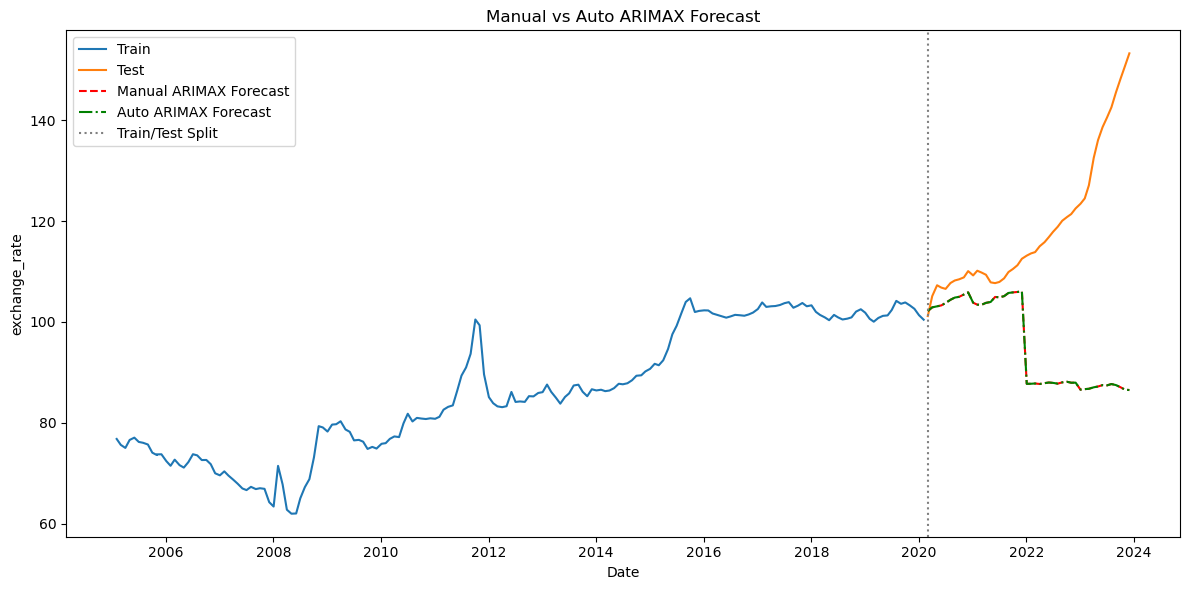

2023-12-31    86.496395
2024-01-31    86.496395
2024-02-29    86.496395
2024-03-31    86.496395
2024-04-30    86.496395
2024-05-31    86.496395
2024-06-30    86.496395
2024-07-31    86.496395
2024-08-31    86.496395
2024-09-30    86.496395
2024-10-31    86.496395
2024-11-30    86.496395
Freq: ME, Name: Forecast, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\3181080726.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')


In [206]:
plt.figure(figsize=(12, 6))

#  train and test
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')

# manual ARIMAX forecast
plt.plot(test_y.index, forecast, label='Manual ARIMAX Forecast', color='red', linestyle='--')

# auto ARIMAX forecast
plt.plot(test_y.index, auto_forecast, label='Auto ARIMAX Forecast', color='green', linestyle='-.')

plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Manual vs Auto ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

#  Preparing last known exogenous values and repeat for 12 months
last_known_exog = df.drop(columns='exchange_rate').iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

#  Forecast the next 12 months using the fitted model
future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)
forecast_mean = future_forecast.predicted_mean

# Generate datetime index for next 12 months
last_date = df.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')

# Create forecast Series
forecast_series = pd.Series(forecast_mean.values, index=future_index, name='Forecast')

# Display forecast
print(forecast_series)

# Arimax considering only the features that have good correlation with the target variable

## checking for features that have high correlation with the target variable

In [207]:
df = pd.read_csv('dfmonthly_modelling.csv', parse_dates=True, index_col='Date')

In [208]:
correlations = df.corr()
print(correlations['exchange_rate'].sort_values(ascending=False))

exchange_rate                                    1.000000
Total Remittances                                0.912210
IBRD loans and IDA credits (DOD, current US$)    0.889706
Imports                                          0.798479
Unemployment Rate                                0.798355
Exports                                          0.772811
Deposit                                          0.736237
Total Debt                                       0.635804
Savings                                          0.558949
182-days Tbill                                   0.323046
91-Day Tbill                                     0.313086
364-days Tbill                                   0.126816
Foreign direct investment                        0.089397
Interbank Rate                                   0.036207
Central Bank Rate                                0.014876
12-Month Inflation(%)                           -0.167633
Lending                                         -0.214734
Overdraft     

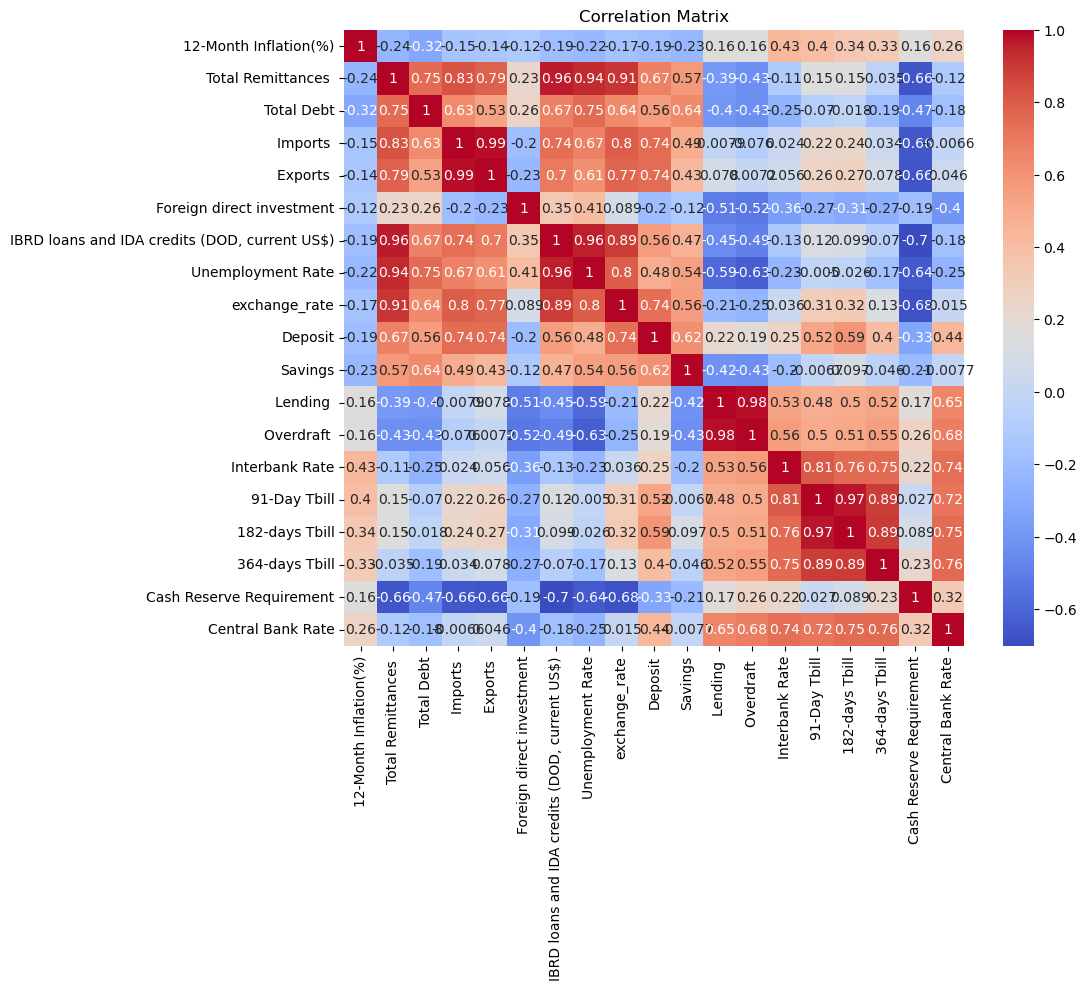

In [209]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## From the heat map correlation it can be seen that some features have good correlation, so i am going to take the features that have a correlation higher than 0.5.

In [210]:
corr_threshold = 0.5
selected_features = correlations['exchange_rate'][abs(correlations['exchange_rate']) > corr_threshold].index.tolist()
selected_features.remove('exchange_rate')  

In [211]:
df_model = df[['exchange_rate'] + selected_features].dropna()
#split into train test data
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

train_y = train['exchange_rate']
train_X = train[selected_features]

test_y = test['exchange_rate']
test_X = test[selected_features]
#Arimax model
model = SARIMAX(train_y, exog=train_X, order=(0,1,0))  #
model_fit = model.fit(disp=False)
#Arimax forecast
forecast_selectedfeatures = model_fit.forecast(steps=len(test_y), exog=test_X)

# Prepare exogenous inputs for next 12 months using last known values
last_known_exog = train_X.iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

# Forecast next 12 months
future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)

# Create future date index
future_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')

future_series = pd.Series(future_forecast.predicted_mean.values, index=future_index)

print(future_series)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2020-02-29    100.44
2020-03-31    100.44
2020-04-30    100.44
2020-05-31    100.44
2020-06-30    100.44
2020-07-31    100.44
2020-08-31    100.44
2020-09-30    100.44
2020-10-31    100.44
2020-11-30    100.44
2020-12-31    100.44
2021-01-31    100.44
Freq: ME, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipyk

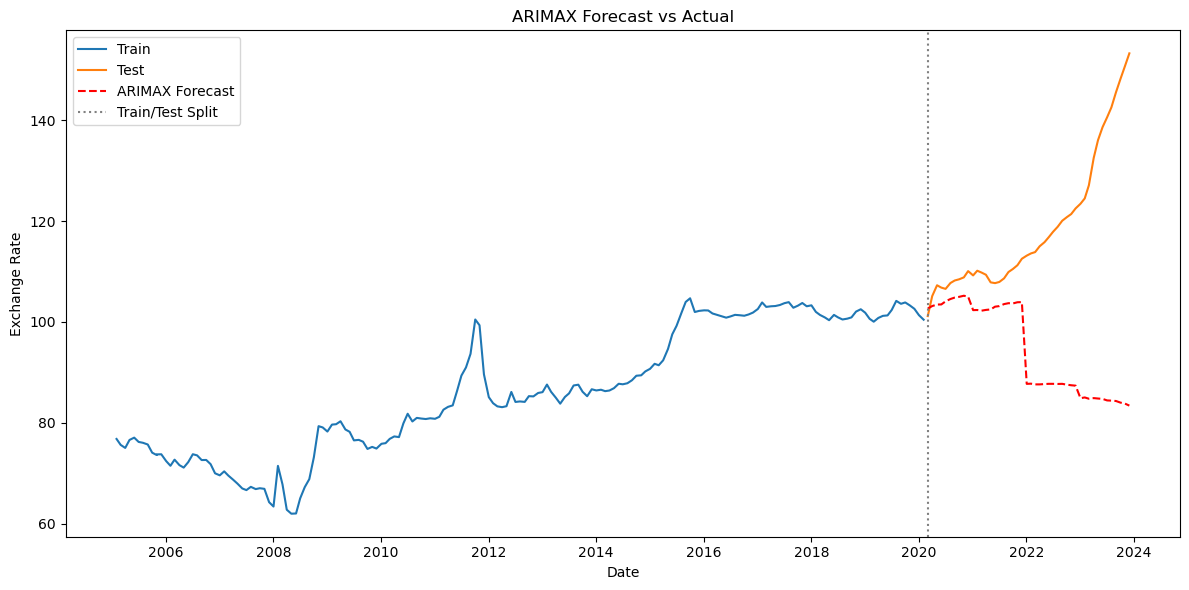

In [212]:
# Arimax plot
plt.figure(figsize=(12,6))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')
plt.plot(test_y.index, forecast_selectedfeatures, label='ARIMAX Forecast', color='red', linestyle='--')
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [213]:
mse = mean_squared_error(test_y, forecast_selectedfeatures)
mae = mean_absolute_error(test_y, forecast_selectedfeatures)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 1039.3363
MAE: 24.2880


## AUTO ARIMAX

In [249]:
auto_model = auto_arima(
    train_y, 
    exogenous=train_X, 
    seasonal=False,  
    stepwise=False,   
    trace=True,      
    error_action='ignore',  
    suppress_warnings=True,
    max_order=None 
)

print("Best ARIMA order:", auto_model.order)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.249, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688.772, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=689.034, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=690.618, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=691.904, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=693.371, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.925, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=689.428, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=690.633, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=693.755, Time=0.59 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=690.921, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=690.442, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

In [221]:
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), trend=None)
model_fit = model.fit(disp=False)
# Forecast
auto_forecast = model_fit.forecast(steps=len(test_y), exog=test_X)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-pac

In [222]:
mse = mean_squared_error(test_y, auto_forecast)
mae = mean_absolute_error(test_y, auto_forecast)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 1056.5727
MAE: 24.6258


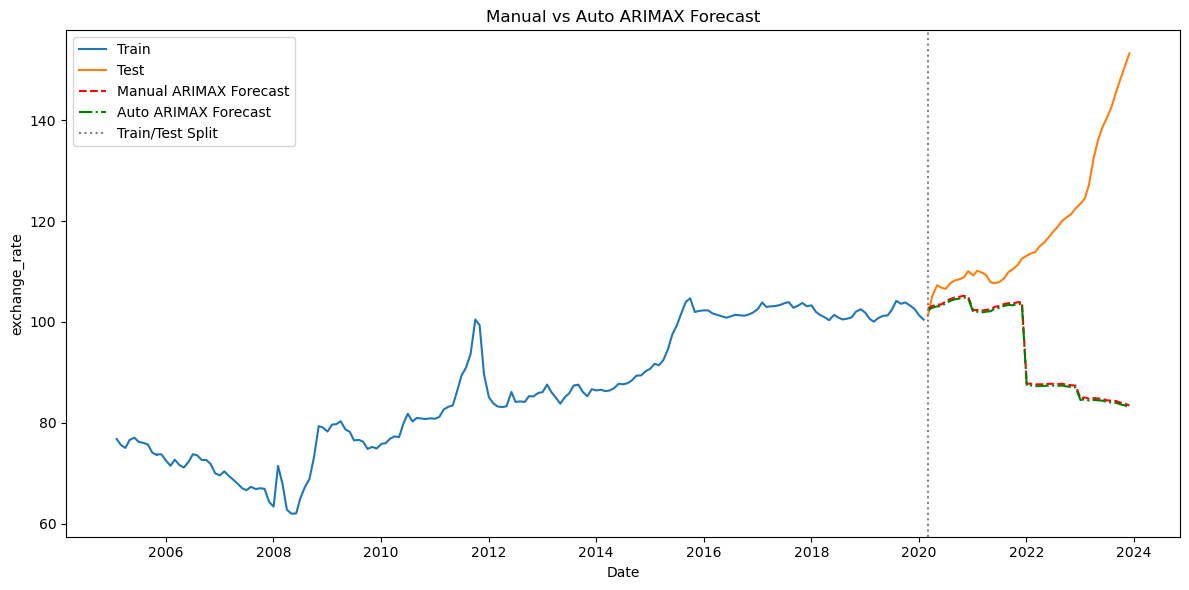

In [223]:
plt.figure(figsize=(12, 6))

# Plot train and test
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')

# Plot manual ARIMAX forecast
plt.plot(test_y.index, forecast_selectedfeatures, label='Manual ARIMAX Forecast', color='red', linestyle='--')

# Plot auto ARIMAX forecast
plt.plot(test_y.index, auto_forecast, label='Auto ARIMAX Forecast', color='green', linestyle='-.')

# Train/test split marker
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Manual vs Auto ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

 from the plot as well from the error computation it can be seen that the manual ARIMAX is better than the auto fitted for selected features.

In [226]:
# Forcasting
last_known_exog = df_model.drop(columns='exchange_rate').iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)
forecast_mean = future_forecast.predicted_mean

last_date = df_model.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')

forecast_series = pd.Series(forecast_mean.values, index=future_index, name='Forecast')

print(forecast_series)

2023-12-31    83.055617
2024-01-31    83.055617
2024-02-29    83.055617
2024-03-31    83.055617
2024-04-30    83.055617
2024-05-31    83.055617
2024-06-30    83.055617
2024-07-31    83.055617
2024-08-31    83.055617
2024-09-30    83.055617
2024-10-31    83.055617
2024-11-30    83.055617
Freq: ME, Name: Forecast, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\2291762861.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')


# arimax considering only some  features 

In [227]:
df.head()

,12-Month Inflation(%),Total Remittances,Total Debt,Imports,Exports,Foreign direct investment,"IBRD loans and IDA credits (DOD, current US$)",Unemployment Rate,exchange_rate,Deposit,Savings,Lending,Overdraft,Interbank Rate,91-Day Tbill,182-days Tbill,364-days Tbill,Cash Reserve Requirement,Central Bank Rate
Date,,,,,,,,,,,,,,,,,,,
2005-01-31,14.87,28564.0,737448.80,6739990276,5341992293,-11524455.87,2663224000,2.74,76.80,3.08,0.97,12.12,13.14,8.72,8.26,8.76,10.547445,6.0,9.137441
2005-02-28,13.94,26056.0,737771.91,6739990276,5341992293,-11524455.87,2663224000,2.74,75.62,3.47,0.96,12.35,13.82,8.14,8.59,8.96,10.547445,6.0,9.137441
2005-03-31,14.15,31219.0,721187.30,6739990276,5341992293,-11524455.87,2663224000,2.74,75.02,3.75,0.98,12.84,14.03,8.13,8.63,8.91,10.547445,6.0,9.137441
2005-04-29,16.02,29216.0,731506.31,6739990276,5341992293,-11524455.87,2663224000,2.74,76.60,3.91,1.10,13.12,14.00,8.28,8.68,8.92,10.547445,6.0,9.137441
2005-05-31,14.78,32358.0,728452.10,6739990276,5341992293,-11524455.87,2663224000,2.74,77.06,4.05,1.07,13.11,13.94,8.30,8.66,9.02,10.547445,6.0,9.137441


In [228]:
# Define target and manually selected exogenous features
target_col = 'exchange_rate'
selected_features = ['12-Month Inflation(%)', 'Total Remittances ', 'Total Debt','Foreign direct investment','Deposit','Savings','Lending ','Overdraft ','Interbank Rate','91-Day Tbill','182-days Tbill','364-days Tbill','Central Bank Rate']

In [229]:
print(df.columns.tolist())

['12-Month Inflation(%)', 'Total Remittances ', 'Total Debt', 'Imports ', 'Exports ', 'Foreign direct investment', 'IBRD loans and IDA credits (DOD, current US$)', 'Unemployment Rate', 'exchange_rate', 'Deposit', 'Savings', 'Lending ', 'Overdraft ', 'Interbank Rate', '91-Day Tbill', '182-days Tbill', '364-days Tbill', 'Cash Reserve Requirement', 'Central Bank Rate']


In [230]:
df_model = df[[target_col] + selected_features].dropna()
# split into train test data
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

train_y = train[target_col]
train_X = train[selected_features]

test_y = test[target_col]
test_X = test[selected_features]
# Arimax model
model = SARIMAX(train_y, exog=train_X, order=(0,1,0))  #
model_fit = model.fit(disp=False)
# Arimax forecast
forecast_selectedfeatures = model_fit.forecast(steps=len(test_y), exog=test_X)

last_known_exog = train_X.iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

# Forecast next 12 months
future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)

# Create future date index
future_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')

# Build forecasted series
future_series = pd.Series(future_forecast.predicted_mean.values, index=future_index)

print(future_series)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2020-02-29    100.44
2020-03-31    100.44
2020-04-30    100.44
2020-05-31    100.44
2020-06-30    100.44
2020-07-31    100.44
2020-08-31    100.44
2020-09-30    100.44
2020-10-31    100.44
2020-11-30    100.44
2020-12-31    100.44
2021-01-31    100.44
Freq: ME, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipyk

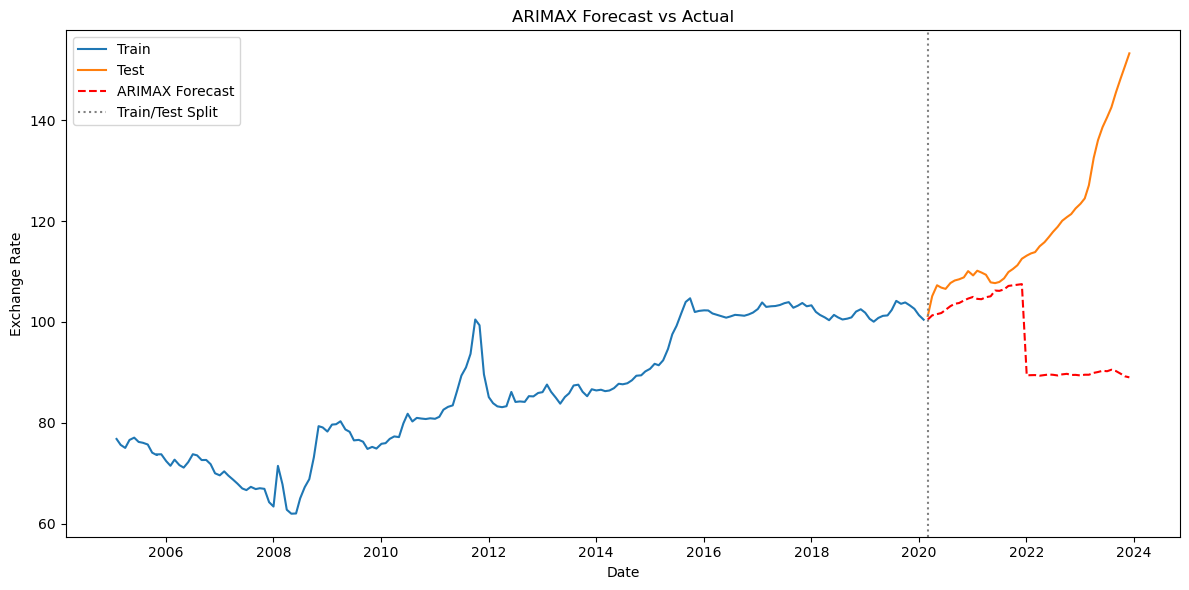

In [231]:
# Arimax plot
plt.figure(figsize=(12,6))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')
plt.plot(test_y.index, forecast_selectedfeatures, label='ARIMAX Forecast', color='red', linestyle='--')
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [232]:
mse = mean_squared_error(test_y, forecast_selectedfeatures)
mae = mean_absolute_error(test_y, forecast_selectedfeatures)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 859.7790
MAE: 21.8893


## AUTO ARIMAX

In [233]:
auto_model = auto_arima(
    train_y, 
    exogenous=train_X, 
    seasonal=False,  
    stepwise=False,   
    trace=True,      
    error_action='ignore',  
    suppress_warnings=True,
    max_order=None 
)

print("Best ARIMA order:", auto_model.order)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.249, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688.772, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=689.034, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=690.618, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=691.904, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=693.371, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.925, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=689.428, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=690.633, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=693.755, Time=0.58 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=690.921, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=690.442, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

In [234]:
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), trend=None)
model_fit = model.fit(disp=False)
# Forecast
auto_forecast = model_fit.forecast(steps=len(test_y), exog=test_X)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-pac

In [235]:
mse = mean_squared_error(test_y, auto_forecast)
mae = mean_absolute_error(test_y, auto_forecast)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 876.8877
MAE: 22.2766


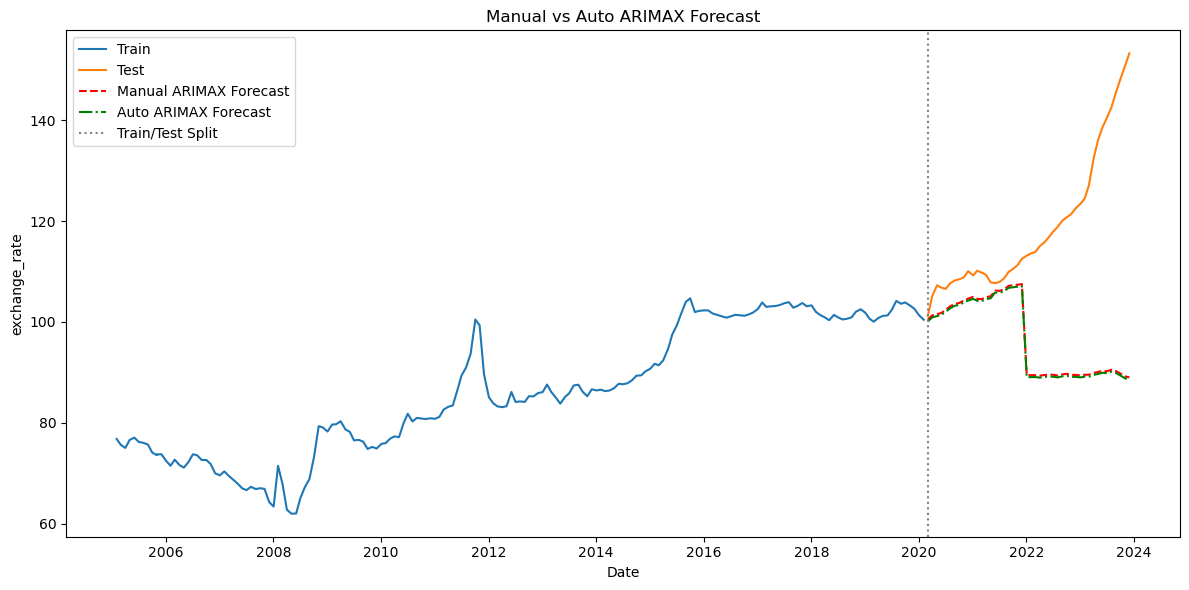

In [236]:
plt.figure(figsize=(12, 6))

# Plot train and test
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')

# Plot manual ARIMAX forecast
plt.plot(test_y.index, forecast_selectedfeatures, label='Manual ARIMAX Forecast', color='red', linestyle='--')

# Plot auto ARIMAX forecast
plt.plot(test_y.index, auto_forecast, label='Auto ARIMAX Forecast', color='green', linestyle='-.')

# Train/test split marker
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Manual vs Auto ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

Based on the error and the plot the manual one gives better forecast than the auto filled ARIMA

In [237]:
# Forcasting
last_known_exog = df_model.drop(columns='exchange_rate').iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)
forecast_mean = future_forecast.predicted_mean

last_date = df_model.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')

forecast_series = pd.Series(forecast_mean.values, index=future_index, name='Forecast')

print(forecast_series)

2023-12-31    88.616624
2024-01-31    88.616624
2024-02-29    88.616624
2024-03-31    88.616624
2024-04-30    88.616624
2024-05-31    88.616624
2024-06-30    88.616624
2024-07-31    88.616624
2024-08-31    88.616624
2024-09-30    88.616624
2024-10-31    88.616624
2024-11-30    88.616624
Freq: ME, Name: Forecast, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\2291762861.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')


# ARIMAX with features having correlation > 0.7

In [238]:
corr_threshold = 0.7
selected_features = correlations['exchange_rate'][abs(correlations['exchange_rate']) > corr_threshold].index.tolist()
selected_features.remove('exchange_rate')  

In [239]:
df_model = df[['exchange_rate'] + selected_features].dropna()
# split into train test data
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

train_y = train['exchange_rate']
train_X = train[selected_features]

test_y = test['exchange_rate']
test_X = test[selected_features]
# Arimax model
model = SARIMAX(train_y, exog=train_X, order=(0,1,0))  #
model_fit = model.fit(disp=False)
# Arimax forecast
forecast_selectedfeatures = model_fit.forecast(steps=len(test_y), exog=test_X)
# Prepare exogenous inputs for next 12 months using last known values
last_known_exog = train_X.iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

# Forecast next 12 months
future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)

# Create future date index
future_index = pd.date_range(start=train_y.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')

future_series = pd.Series(future_forecast.predicted_mean.values, index=future_index)

print(future_series)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2020-02-29    100.44
2020-03-31    100.44
2020-04-30    100.44
2020-05-31    100.44
2020-06-30    100.44
2020-07-31    100.44
2020-08-31    100.44
2020-09-30    100.44
2020-10-31    100.44
2020-11-30    100.44
2020-12-31    100.44
2021-01-31    100.44
Freq: ME, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipyk

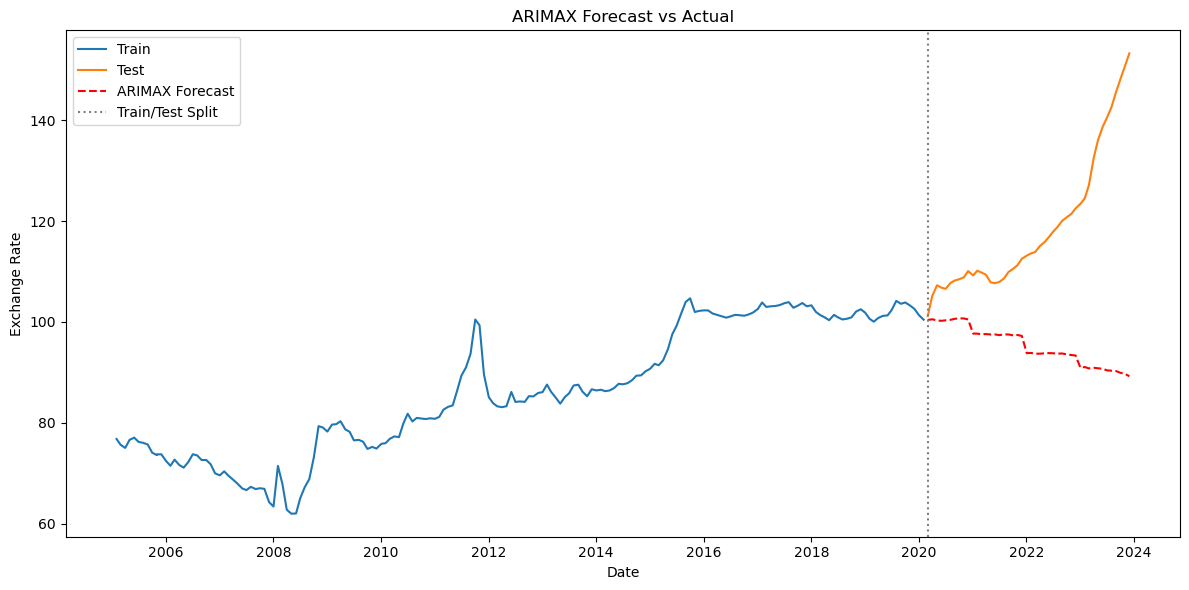

In [240]:
# Arimax plot
plt.figure(figsize=(12,6))
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')
plt.plot(test_y.index, forecast_selectedfeatures, label='ARIMAX Forecast', color='red', linestyle='--')
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title('ARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [241]:
mse = mean_squared_error(test_y, forecast_selectedfeatures)
mae = mean_absolute_error(test_y, forecast_selectedfeatures)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 831.2872
MAE: 23.3388


AUTO ARIMAX

In [242]:
auto_model = auto_arima(
    train_y, 
    exogenous=train_X, 
    seasonal=False,  
    stepwise=False,   
    trace=True,      
    error_action='ignore',  
    suppress_warnings=True,
    max_order=None 
)

print("Best ARIMA order:", auto_model.order)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.249, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688.772, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=689.034, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=690.618, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=691.904, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=693.371, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.925, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=689.428, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=690.633, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=693.755, Time=0.60 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=690.921, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=690.442, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   :

In [244]:
model = SARIMAX(train_y, exog=train_X, order=(0, 1, 1), trend=None)
model_fit = model.fit(disp=False)

auto_forecast = model_fit.forecast(steps=len(test_y), exog=test_X)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-pac

In [245]:
mse = mean_squared_error(test_y, auto_forecast)
mae = mean_absolute_error(test_y, auto_forecast)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 848.4428
MAE: 23.7035


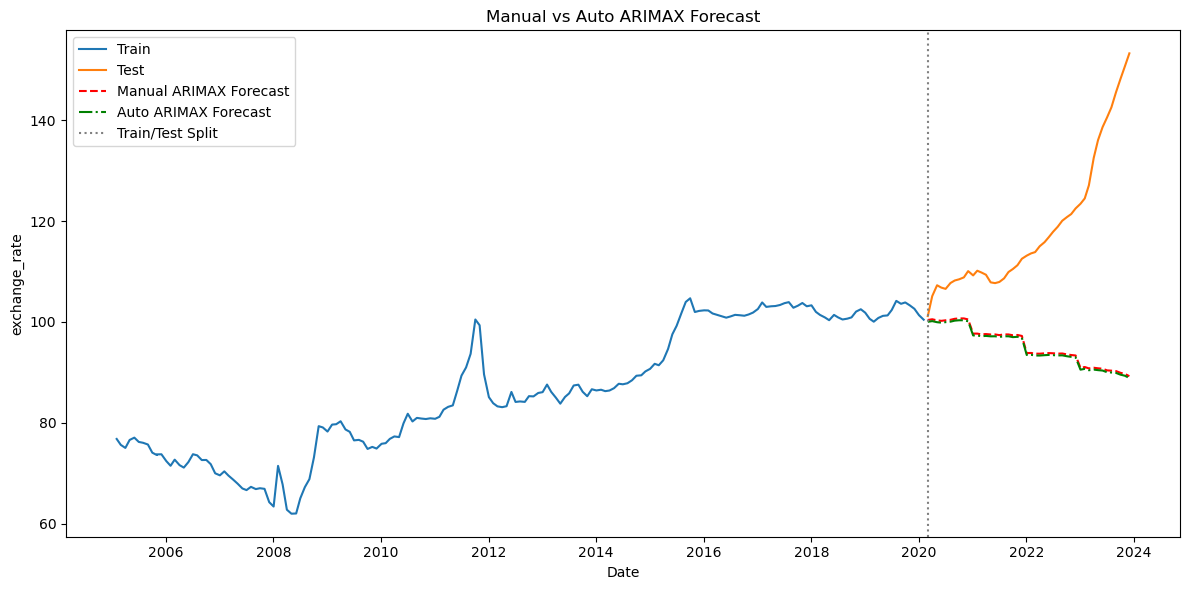

In [246]:
plt.figure(figsize=(12, 6))

# Plot train and test
plt.plot(train_y.index, train_y, label='Train')
plt.plot(test_y.index, test_y, label='Test')

# Plot manual ARIMAX forecast
plt.plot(test_y.index, forecast_selectedfeatures, label='Manual ARIMAX Forecast', color='red', linestyle='--')

# Plot auto ARIMAX forecast
plt.plot(test_y.index, auto_forecast, label='Auto ARIMAX Forecast', color='green', linestyle='-.')

# Train/test split marker
plt.axvline(x=test_y.index[0], color='gray', linestyle=':', label='Train/Test Split')

plt.title('Manual vs Auto ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

In [247]:
# Forcasting
last_known_exog = df_model.drop(columns='exchange_rate').iloc[-1:]
future_exog = pd.concat([last_known_exog] * 12, ignore_index=True)

future_forecast = model_fit.get_forecast(steps=12, exog=future_exog)
forecast_mean = future_forecast.predicted_mean

last_date =df_model.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')

forecast_series = pd.Series(forecast_mean.values, index=future_index, name='Forecast')

print(forecast_series)

2023-12-31    88.875604
2024-01-31    88.875604
2024-02-29    88.875604
2024-03-31    88.875604
2024-04-30    88.875604
2024-05-31    88.875604
2024-06-30    88.875604
2024-07-31    88.875604
2024-08-31    88.875604
2024-09-30    88.875604
2024-10-31    88.875604
2024-11-30    88.875604
Freq: ME, Name: Forecast, dtype: float64


C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\user\AppData\Local\Temp\ipykernel_16644\850355141.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=12, freq='M')
